In [1]:
run ../initialize.ipynb

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/seaborn-0.8.1-py3.4.egg/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


Lax Version : 1.5.2


In [2]:
from Pre_trigger_peaks import Pre_Trigger
#from PI_after_s2 import S2_ionization

In [3]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']

Processed data available selection: 0 rows removed (100.00% passed)
Source in place selection: 7257 rows removed (4.56% passed)
Source in place selection: 1190 rows removed (84.35% passed)
Source in place selection: 7146 rows removed (6.02% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [4]:
hax.init(experiment='XENON1T', 
        pax_version_policy = '6.8.0',
        main_data_paths = ['/project2/lgrandi/xenon1t/processed', '/project/lgrandi/xenon1t/processed'],
        minitree_paths = ['/scratch/midway2/jpienaar/minitrees/',
                         '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0',
                         '/project/lgrandi/xenon1t/minitrees/pax_v6.8.0',
                         ],
        ) 

In [11]:
#Main
dataset_name=datasets_bkg.name.iloc[0]
df_PI = hax.minitrees.load(dataset_name,
                         #treemakers=[S2_ionization, 'Basics'],
                         treemakers=[Pre_Trigger, 'Basics'],
                         preselection=None,
                         force_reload=True,
                         )
cache_file_name = '/home/jpienaar/batchjobs/%s_S2_Ionization.hdf5' %dataset_name
hax.minitrees.save_cache_file(df_PI,cache_file_name)

Run 170202_1747: Making Basics minitree: 100%|██████████| 21603/21603 [00:36<00:00, 596.48it/s]


In [12]:
dataset_name=datasets_bkg.name.iloc[0]
cache_file_name = '/home/jpienaar/batchjobs/%s_S2_Ionization.hdf5' %dataset_name
df = hax.minitrees.load(cache_file = cache_file_name)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/minitrees.py:585: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history


## Standard Treatment

In [ ]:
df.columns

In [ ]:
plt.hist(df_PI.time_since_s2/1000, bins=100, range=[0, 1000])

In [ ]:
#Binning
pax_config = configuration.load_configuration('XENON1T')
R_tpc = pax_config['DEFAULT']['tpc_radius']
window_length=10**8
t_bins=np.linspace(0, window_length, 201)
t_bin_width=t_bins[1:]-t_bins[:-1]
r_bins=np.linspace(0, (R_tpc)**2, 101)
dist_bins=np.linspace(0, (2*R_tpc), 101)
s2_bins   = np.linspace(2, 6, 51)
s2_p_bins = np.linspace(0, 4, 51)

#Define Blank Hists
livet_histogram=Histdd(bins=[t_bins,
                             s2_bins,
                             ], 
                        axis_names=['delta_T',
                                    's2_area',
                                    ]) 

livet_weights_histogram=Histdd(bins=[t_bins,
                             s2_bins,
                             ], 
                        axis_names=['delta_T',
                                    's2_area',
                                    ]) 

events_histogram=Histdd(bins=[t_bins,
                              s2_bins,
                             ], 
                        axis_names=['delta_T',
                                    's2_area'
                                    ]) 

weights_histogram=Histdd(bins=[t_bins,
                              s2_bins,
                             ], 
                        axis_names=['delta_T',
                                    's2_area'
                                    ]) 


peaks_histogram=Histdd(bins=[t_bins,
                             s2_p_bins,
                             ], 
                        axis_names=['delta_T',
                                    'peak_area'
                                    ]) 


dt_r2_histogram=Histdd(bins=[t_bins,
                             r_bins,
                             ], 
                        axis_names=['delta_T',
                                    'r_dist',
                                    ]) 

weights_dt_r2_histogram=Histdd(bins=[t_bins,
                             r_bins,
                             ], 
                        axis_names=['delta_T',
                                    'r_dist',
                                    ]) 


dt_xy_histogram=Histdd(bins=[t_bins,
                           dist_bins,
                           dist_bins,
                           ],
                    axis_names=['delta_T',
                                 'x_dist',
                                 'y_dist',
                                 ])

In [ ]:
#For each unique s2 investigate subsquent S2s
num_s2s=len(unique_s2s)
for s2 in tqdm(unique_s2s):
    #window_length=window_length
    temp_df = df.loc[(df.global_time>(s2[0]))&(df.global_time<(s2[0]+window_length))]
    
    #Find unique events within 1ms
    subsequent_events=pd.unique(temp_df['event_number'].values)
    event_info=[]
    for event_id in subsequent_events:
        event_df=temp_df[temp_df.event_number==event_id].iloc[0]
        event_info.append([np.nanmin([event_df.s1_time, event_df.s2_time]), event_df.event_start])
    
    #Binning Info of events
    bin_allocation_start = np.digitize([x[1]-s2[0] for x in event_info], bins=t_bins)
    bin_allocation_end = np.digitize([x[0]-s2[0] for x in event_info], bins=t_bins)
    bin_difference=bin_allocation_end-bin_allocation_start
    
    #Determine Live_time conisdered in each time bin
    start_time=[x[1]-s2[0] for x in event_info]
    end_time=[np.min([x[0]-s2[0], window_length]) for x in event_info]
    
    live_time_array=[]
    #Bin number in digitize of by 1
    for idx, bin_allocation in enumerate(bin_difference):
        if bin_allocation == 0:
            live_time_array.append([t_bins[bin_allocation_start[idx]-1], 
                                    (end_time[idx]-start_time[idx])/t_bin_width[bin_allocation_start[idx]-1]])
        elif bin_allocation == 1:
            live_time_array.append([t_bins[bin_allocation_start[idx]-1], 
                                   (t_bins[bin_allocation_start[idx]]-start_time[idx])/t_bin_width[bin_allocation_start[idx]-1]])
            if bin_allocation_start[idx]<len(t_bins)-1:
                live_time_array.append([t_bins[bin_allocation_start[idx]], 
                                    (end_time[idx]-t_bins[bin_allocation_start[idx]])/t_bin_width[bin_allocation_start[idx]]])
        elif bin_allocation >1:
            live_time_array.append([t_bins[bin_allocation_start[idx]-1], 
                                   (t_bins[bin_allocation_start[idx]]-start_time[idx])/t_bin_width[bin_allocation_start[idx]-1]])
            for index in range(bin_allocation-1):
                if bin_allocation_start[idx]+index<len(t_bins)-1:
                    live_time_array.append([t_bins[bin_allocation_start[idx]+index],1])
            if bin_allocation_start[idx]+(bin_allocation-1)<len(t_bins)-1:
                live_time_array.append([t_bins[bin_allocation_start[idx]+(bin_allocation-1)], 
                                        (end_time[idx]-t_bins[bin_allocation_start[idx]+(bin_allocation-1)])/t_bin_width[bin_allocation_start[idx]+(bin_allocation-1)]])
          
    #Some Extra Branches
    r_s2=s2[1]**2+s2[1]**2
    
    temp_df['x_dist'] = temp_df['x_p_tpf']-s2[1]
    temp_df['y_dist'] = temp_df['y_p_tpf']-s2[2]
    temp_df['r_dist'] = np.sqrt(temp_df['x_dist']**2+temp_df['y_dist']**2)
    
    temp_df['alpha'] = np.arccos((temp_df['r_dist']**2+r_s2**2-R_tpc**2)/(2*r_s2*temp_df['r_dist']))
    temp_df['area_norm'] = temp_df['alpha'].fillna(np.pi) 
    temp_df['norm'] = temp_df['area_norm']/np.pi
    
    #Binning for bin width rate correction
    peak_bins=np.digitize(temp_df['global_time'].values-s2[0], t_bins)
  
    
    #Fill Live_T Histogram
    histogram=Histdd([x[0]+1 for x in live_time_array],
                     [np.log10(s2[3])]*len(live_time_array),
                     weights=[x[1] for x in live_time_array],
                     axis_names=['delta_T',
                                 's2_area',
                                 ], 
                     bins=[t_bins,
                           s2_bins,
                           ])
    livet_histogram+=histogram

    #Fill Live_T Histogram
    histogram=Histdd([x[0]+1 for x in live_time_array],
                     [np.log10(s2[3])]*len(live_time_array),
                     weights=[x[1]**2 for x in live_time_array],
                     axis_names=['delta_T',
                                 's2_area',
                                 ], 
                     bins=[t_bins,
                           s2_bins,
                           ])
    livet_weights_histogram+=histogram

    
    #Fill Events Histogram according to Peak Size
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     np.log10(temp_df['area'].values),
                     weights=1/t_bin_width[peak_bins-1],
                     axis_names=['delta_T',
                                 'peak_area',
                                 ], 
                     bins=[t_bins,
                           s2_p_bins,
                           ])
    peaks_histogram+=histogram
    
    #Fill Events Histogram according to S2 Size
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     [np.log10(s2[3])]*len(temp_df),
                     weights=1/t_bin_width[peak_bins-1],
                     axis_names=['delta_T',
                                 's2_area',
                                 ], 
                     bins=[t_bins,
                           s2_bins,
                           ])
    events_histogram+=histogram
    
    #Fill weights histogram for Events Histogram according to S2 Size
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     [np.log10(s2[3])]*len(temp_df),
                     weights=(1/t_bin_width[peak_bins-1])**2,
                     axis_names=['delta_T',
                                 's2_area',
                                 ], 
                     bins=[t_bins,
                           s2_bins,
                           ])
    weights_histogram+=histogram
            
    ##Fill TR_Dist Histogram
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     (temp_df['r_dist'].values)**2,
                     weights=1/temp_df['norm'].values,
                     axis_names=['delta_T',
                                 'r_dist',
                                 ], 
                     bins=[t_bins,
                           r_bins,
                           ])
    dt_r2_histogram+=histogram
    
    ##Fill Weight TR_Dist Histogram
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     (temp_df['r_dist'].values)**2,
                     weights=(1/temp_df['norm'].values)**2,
                     axis_names=['delta_T',
                                 'r_dist',
                                 ], 
                     bins=[t_bins,
                           r_bins,
                           ])
    weights_dt_r2_histogram+=histogram
    
    ##Fill TXY_Dist Histogram
    histogram=Histdd(temp_df['global_time'].values-s2[0],
                     temp_df['x_dist'].values,
                     temp_df['y_dist'].values,
                     axis_names=['delta_T',
                                 'x_dist',
                                 'y_dist',
                                 ], 
                     bins=[t_bins,
                           dist_bins,
                           dist_bins,
                           ])
    dt_xy_histogram+=histogram

In [ ]:
rn_livet=events_histogram
plt.figure(figsize=(10, 8))
rn_livet.plot(norm=LogNorm())
plt.xlim([t_bins[1], 10**8])


In [ ]:
rn_livet=weights_histogram
plt.figure(figsize=(10, 8))
rn_livet.plot(norm=LogNorm())
plt.xlim([t_bins[1], 10**8])




## A La Tianyu

In [ ]:
df.columns

In [ ]:
window_length=10**8
t_bins=np.linspace(0, window_length, 201)
t_bin_width=t_bins[1:]-t_bins[:-1]

delay_array=[]
live_time_array=[]
for key, peak in tqdm(df.iloc[0:].iterrows()):
    temp_df = df.loc[((df.s2_time)<peak.global_time)&
                     ((df.s2_time)>peak.global_time-window_length)&
                    (df.event_number!=peak.event_number)]   
    if len(temp_df)==0:
        continue
    else:      
        temp_df['time_delay']=peak.global_time-temp_df.s2_time
        s2_diff=np.nanmin(temp_df.time_delay.values)
        
        delay_array.append(s2_diff)
              
        #Binning Info of events
        start_diff = s2_diff-peak.global_time-peak.event_start
        end_diff = s2_diff+(np.nanmin([peak.s1_time, peak.s2_time])-peak.global_time)
        
        bin_allocation_start = np.digitize(start_diff, bins=t_bins)
        bin_allocation_end = np.digitize(end_diff, bins=t_bins)
        bin_difference=bin_allocation_end-bin_allocation_start
    
        #Determine Live_time considered in each time bin
        start_time=start_diff
        end_time=end_diff
    
        #Bin number in digitize of by 1           
        if bin_difference == 0:
            live_time_array.append([t_bins[bin_allocation_start-1],
                                    (end_time-start_time)/t_bin_width[bin_allocation_start-1]])
        elif bin_difference == 1:
            live_time_array.append([t_bins[bin_allocation_start-1], 
                                   (t_bins[bin_allocation_start]-start_time)/t_bin_width[bin_allocation_start-1]])
            if bin_allocation_start<len(t_bins)-1:
                live_time_array.append([t_bins[bin_allocation_start], 
                                   (end_time-t_bins[bin_allocation_start])/t_bin_width[bin_allocation_start]])
        elif bin_difference > 1:
            live_time_array.append([t_bins[bin_allocation_start-1], 
                                   (t_bins[bin_allocation_start]-start_time)/t_bin_width[bin_allocation_start-1]])
            for index in range(bin_difference-1):
                if bin_allocation_start+index<len(t_bins)-1:
                    live_time_array.append([t_bins[bin_allocation_start+index],1])
            if bin_allocation_start+(bin_difference-1)<len(t_bins)-1:
                live_time_array.append([t_bins[bin_allocation_start+(bin_difference-1)], 
               (end_time-t_bins[bin_allocation_start+(bin_difference-1)])/t_bin_width[bin_allocation_start+(bin_difference-1)]])
        
        
        
        
        
        
        

0it [00:00, ?it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
26100it [53:11,  8.18it/s]


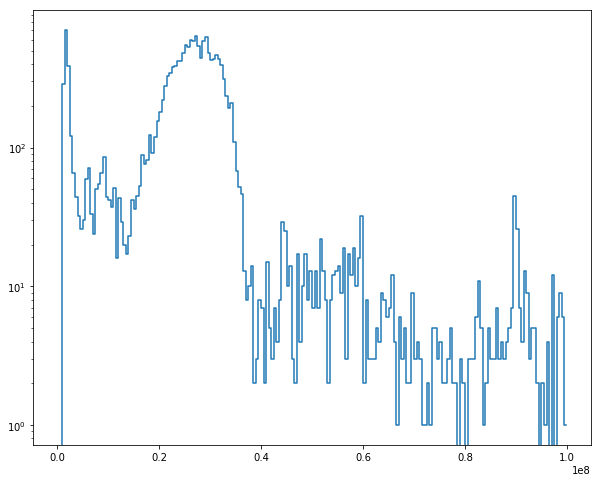

In [ ]:
window_length=10**8
t_bins=np.linspace(0, window_length, 201)
plt.figure(figsize=(10, 8))
histogram=Histdd(delay_array,
                 #weights=[x[1] for x in live_time_array],
                 axis_names=['delta_T',
                                 ],
                 bins=[t_bins,
                           ])
histogram.plot()
plt.yscale('log')

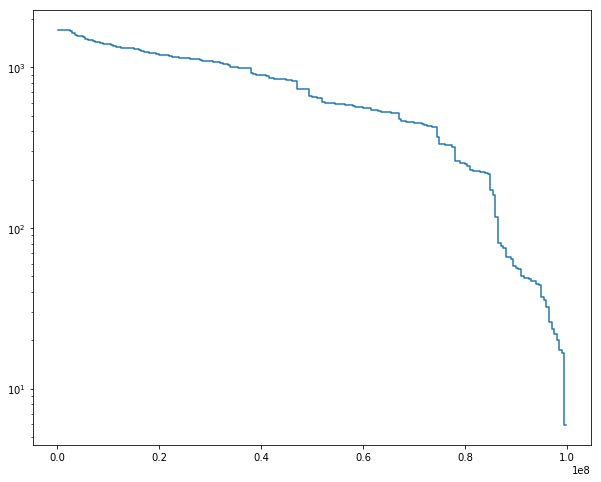

In [10]:
window_length=10**8
t_bins=np.linspace(0, window_length, 201)
plt.figure(figsize=(10, 8))
histogram=Histdd([x[0]+1 for x in live_time_array],
                 weights=[x[1]**2 for x in live_time_array],
                 axis_names=['delta_T',
                                 ],
                 bins=[t_bins,
                           ])
histogram.plot()
plt.yscale('log')

In [ ]:
test=[x[0]+1 for x in live_time_array]

In [ ]:
np.shape(delay_array)

In [ ]:
    histogram=Histdd([x[0]+1 for x in live_time_array],
                     [np.log10(s2[3])]*len(live_time_array),
                     weights=[x[1]**2 for x in live_time_array],
                     axis_names=['delta_T',
                                 's2_area',
                                 ], 
                     bins=[t_bins,
                           s2_bins,
                           ])
    livet_weights_histogram+=histogram